# Mask R-CNN for Object Detection and Segmentation

This is an implementation of [Mask R-CNN](https://arxiv.org/abs/1703.06870) on Python 3, TensorFlow and Keras. <br>
The model classifies objects and generates bounding boxes and segmentation masks for each instance of an object in the image. <br>
It's based on ResNet - Feature Pyramid Network (ResNet-FPN).

For this implementation we used the [Matterport Repository](https://github.com/matterport/Mask_RCNN). <br>
Pre-trained weights with [MS COCO](https://cocodataset.org/#home) were used with technique of transfer learning.

### Install Packages

In [2]:
%%capture

!pip install pickle
!pip install matplotlib
!pip install -U scikit-image==0.16.2
!pip install smart_open[s3]
!pip install boto3
!pip install mrcnn
!pip install imgaug
!pip install opencv-python
!pip install keras==2.3.1  
!pip freeze > requirements.txt
!pip --version >> requirements.txt

### Import Packages

Overall we used packages from the Matterport (mrcnn) for the MASK R-CNN Implemntation, Amazon (boto3) to handle the input pipeline of the stored dataset, Augmentation (imaug) to experiment with Data Augmentation and some general libraries to visualize and evalute the results.

In [55]:
import io
import sys
import os
import itertools
import math
import logging
import json
import re
import random
from collections import OrderedDict
import numpy as np
import matplotlib
import datetime
import time
import cv2

#import pickle # auswertung history nach training
from matplotlib import pyplot as plt
from imgaug import augmenters as iaa
import imageio
import imgaug as ia
from smart_open import smart_open
import boto3

import mrcnn
from mrcnn.config import Config
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
from mrcnn.visualize import display_instances
import mrcnn.model as modellib
from mrcnn.model import log

# Libraries for mAP calculation
from mrcnn.model import compose_image_meta, load_image_gt # mold_image
from mrcnn.utils import compute_ap, extract_bboxes
from numpy import expand_dims, mean, random # seed for reproducable shuffle

# import warnings
# warnings.filterwarnings("ignore")

%matplotlib inline

### Define Global Config
We'll be using a model trained on the MS-COCO dataset.

For inference, we modified the configurations to fit the task. 
To do so, the sub-class GlobalConfig and TrainConfig class override the attributes we need to change.

In [2]:
class GlobalConfig(Config):
    CONFIG_FILE= "parameter.cfg"
    DEFAULT_LOGS_DIR = "./logs"
    H5_MODEL = './mask_rcnn_coco.h5'

global_cfg = GlobalConfig()

### Define and display Train Config
This class contains the default configuration for training.

In [3]:
class TrainConfig(Config):
    """Configuration for training.
    Derives from the base Config class and overrides some values.
    """
    # define the name of the config
    NAME = "sgd_rois2_restnet50_"
    # number of classes (background + bee)
    NUM_CLASSES = 1 + 1
    # number of training steps per epoch ~ Anzahl Trainingsdaten / Batch Size
    STEPS_PER_EPOCH = 640
    # 50% ~ Anzahl Validierungsdaten / Batch Size
    VALIDATION_STEPS = 160
    # extended Settings
    BACKBONE = "resnet50"
    #BACKBONE = "resnet101" # default
    # Batch size is GPUs * images/GPU
    GPU_COUNT = 1
    # Batch size - wie viele Bilder das Modell pro STEP als input erhält
    BATCH_SIZE = 2 # wird automatisch berechnet
    IMAGES_PER_GPU = 2
    
    # resizing will ALWAYS be applied on training
    RESIZE_FACTOR = 1
    
    # image augmentation
    USE_AUGMENTATION = False
    
    NESTEROV = False
    
    LEARNING_RATE = 0.001
    
    # save trained config
    def save_cfg(self, file):
        f = open(file, "w")
        #f.writelines() 
        for a in dir(self):
            if not a.startswith("__") and not callable(getattr(self, a)):
                #print("{:30} {}".format(a, getattr(self, a)))
                f.writelines("{:30} {}".format(a, getattr(self, a))+"\n") 
        f.close()

train_cfg = TrainConfig()

In [4]:
train_cfg.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE          

### Define Dataset Class

In [5]:
class BeeDataset(utils.Dataset):
    """The class for dataset classes.
    We created a new class that adds functions specific to our bee dataset.
    We parse the annotation file, load images and shuffle,assign these data to different datasets, 
    """
    
    # Bucket Name
    bucket = "labeling-test-ai-supported-enbeemoresearchdata-k8wchfbly0wb"
    annotations_path = 's3://labeling-test-ai-supported-enbeemoresearchdata-k8wchfbly0wb/bee-labeling-2k-batch-01/manifests/output/output.manifest'
    
    # load  -> 
    # train_valid_ratio = 0.8 -> split data into train 0.8 train and 0.2 valid
    # test_ratio split = 0.2 -> split train data in 0.8 train and 0.2 test data
    def load_bee(self, subset="train", train_valid_ratio = 0.8, test_ratio = 0.2):
        """Load a subset of the dataset.
        subset: Subset to load: train, validation or test
        """
        # Add classes. We have only one class to add.
        self.add_class("bee", 1, "bee")

        # check if subset is one of this
        assert subset in ["train", "validation", "test"]

        # assign filenames with unique id
        self.filelist=list()
        # assign annotations with unique id
        self.annotationslist=list()

        # define amount of data
        data_size = self.count_data()

        # 0.64 = 0.8 * (1-0.8) -> 80% of data = training
        train_size = int((train_valid_ratio * (1 - test_ratio)) * data_size)
        # 0.2 = 1-0.8 -> 20% of data = validation
        valid_size = int((1-train_valid_ratio) * data_size)
        # 0.16 = 0.8 * 0.2 -> 20% of trainingset is for test
        test_size = int((train_valid_ratio * test_ratio) * data_size)
        
        # create random, std datasets
        # create array with 1-2000 
        shufflea = np.arange(start=1,stop=data_size+1)
        # reproducable shuffle!! dont change!!!! 123
        random.seed(123)
        # shuffle data
        random.shuffle(shufflea)
        
        with smart_open(self.annotations_path, 'rb') as s3_source:

            datasetid = 0
            
            # iterate over each line in annotation file
            for line in s3_source:
                
                # assign a shuffled dataset id of existing dataset
                datasetid += 1
                shuffeldid=shufflea[datasetid-1]
                
                # decode and use line as json
                raw = line.decode('utf8')
                raw_json = json.loads(raw)

                # load image and annotations
                annotation = self.parse_annotations(raw_json['bee-labeling-2k-batch-01']['annotations'])
                image_size = raw_json['bee-labeling-2k-batch-01']['image_size']
                
                # test dataset 
                if subset!="train" and int(shuffeldid) <= train_size:
                    continue

                # validation dataset
                if subset!="test" and int(shuffeldid) > train_size and int(shuffeldid) < (data_size-valid_size):
                    continue

                # train dataset
                if subset!="validation" and int(shuffeldid) >= (data_size-valid_size):
                    continue

                # parse path and file
                path = raw_json['source-ref'].split('/')[2]
                file = raw_json['source-ref'].split('/')[3]
                
                # assign unique file name
                self.filelist.append(file)
                self.annotationslist.append(annotation)
                self.add_image(
                    source="bee", 
                    path=path, 
                    image_id=file,
                    width=image_size[0]['width'],
                    height=image_size[0]['height'],
                    annotations=annotation)
                
    # return amount of available data
    def count_data(self):
        """Return the amount of available data."""
        size = 0
        with smart_open(self.annotations_path, 'rb') as s3_source:      
            # iterate over each line in annotation file
            for line in s3_source:
                size += 1
        return size
                
    # create image reference 
    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "bee":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

    # load annotation from annotation file    
    def parse_annotations(self,annotation_raw):
        """Parse BBoxes 
        of a line in annotation file
        """
        # create list of annotionsions
        annotations = list()

        # create entry for each annotation
        for annotation in annotation_raw:
            top = annotation['top']
            left = annotation['left']
            height = annotation['height']
            width = annotation['width']
            annotations.append([top, left, height, width])

        return annotations

    # load image from s3 bucket
    def load_image(self, image_id):      
        """Load the specified image and 
        return a [H,W,3] Numpy array.
        """
        file = self.filelist[image_id]

        # load file from bucket
        with io.BytesIO() as f:
            boto3.client("s3").download_fileobj(Bucket=self.bucket, Key=file, Fileobj=f)
            f.seek(0)
            return plt.imread(f)  

    # load the masks for an image
    def load_mask(self, image_id):
        """Load instance masks for the given image.
        Method is overrided load instance masks and return them in the form of am
        array of binary masks of shape [height, width, instances].
        Returns:
            masks: A bool array of shape [height, width, instance count] with
                a binary mask per instance.
            class_ids: a 1D array of class IDs of the instance masks.
        """
        # get details of image
        info = self.image_info[image_id]
        annotations = self.annotationslist[image_id]
        
        #[[top, left, height, width],...]
        # create one array for all masks, each on a different channel
        mask = np.zeros([info["height"], info["width"], len(info["annotations"])],
                        dtype=np.uint8)

        # create masks
        class_ids = list()
        for i in range(len(annotations)):
            box = annotations[i]
            t=box[0] 
            l=box[1]
            h=box[2]
            w=box[3]
            mask[t:t+h, l:l+w, i] = 1
            class_ids.append(self.class_names.index('bee'))

        # return masks and classes (only bee's)
        return mask, np.asarray(class_ids, dtype='int32')  

### Create Dataset

In [6]:
# train set
train_set = BeeDataset()
train_set.load_bee("train")
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))

# validation set
validation_set = BeeDataset()
validation_set.load_bee("validation")
validation_set.prepare()
print('Validation: %d' % len(validation_set.image_ids))

# test set
test_set = BeeDataset()
test_set.load_bee("test")
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

Train: 1280
Validation: 400
Test: 320


### Visualize Dataset

In [14]:
# display 3 data of each dataset
def show_dateset(dataset,img_id):

    # load image
    img = dataset.load_image(img_id)
    
    # load masks
    mask, class_ids = dataset.load_mask(img_id)
    bbox = utils.extract_bboxes(mask)
    
    # create colors and class labels
    colors = ['#FC5555' for _ in range(100)]
    captions = [ 'bee ' + str( _ +1) for _ in range(100)]
    
    # call display instances of mask r-cnn utils
    visualize.display_instances(image=img*255, boxes=bbox, masks=mask, class_ids=class_ids, 
                            class_names=train_set.class_names, show_mask=False, colors=colors,
                           captions=captions)
    print()

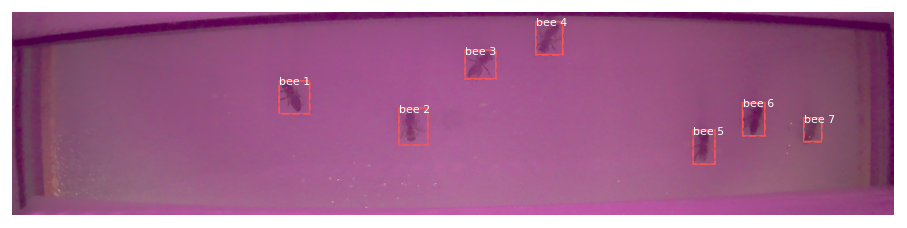

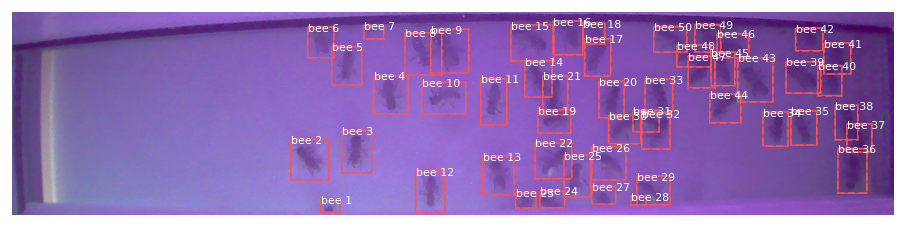

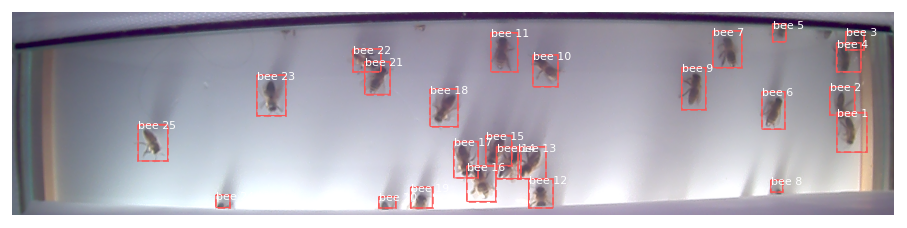

In [21]:
# show that datasets are homogen over all daytimes
show_dateset(train_set,1)
show_dateset(train_set,len(train_set.image_ids)//2)
show_dateset(train_set,len(train_set.image_ids)-100)

### Define Mask R-CNN Class

In [7]:
class BeeMaskRCNN(modellib.MaskRCNN):

    def __init__(self, mode, config, model_dir):
        """
        mode: Either "training" or "inference"
        config: A Sub-class of the Config class
        model_dir: Directory to save training logs and trained weights
        """
        assert mode in ['training', 'inference']
        self.mode = mode
        self.config = config
        self.model_dir = model_dir
        self.set_log_dir()
        self.keras_model = self.build(mode=mode, config=config)
        
    def train(self, train_dataset, val_dataset, learning_rate, epochs, layers,
              augmentation=None, custom_callbacks=None, no_augmentation_sources=None):
        """Train the model.
        train_dataset, val_dataset: Training and validation Dataset objects.
        learning_rate: The learning rate to train with
        epochs: Number of training epochs. Note that previous training epochs
                are considered to be done alreay, so this actually determines
                the epochs to train in total rather than in this particaular
                call.
        layers: Allows selecting wich layers to train. It can be:
            - A regular expression to match layer names to train
            - One of these predefined values:
              heads: The RPN, classifier and mask heads of the network
              all: All the layers
              3+: Train Resnet stage 3 and up
              4+: Train Resnet stage 4 and up
              5+: Train Resnet stage 5 and up
        augmentation: Optional. An imgaug (https://github.com/aleju/imgaug)
            augmentation. For example, passing imgaug.augmenters.Fliplr(0.5)
            flips images right/left 50% of the time. You can pass complex
            augmentations as well. This augmentation applies 50% of the
            time, and when it does it flips images right/left half the time
            and adds a Gaussian blur with a random sigma in range 0 to 5.
                augmentation = imgaug.augmenters.Sometimes(0.5, [
                    imgaug.augmenters.Fliplr(0.5),
                    imgaug.augmenters.GaussianBlur(sigma=(0.0, 5.0))
                ])
	    custom_callbacks: Optional. Add custom callbacks to be called
	        with the keras fit_generator method. Must be list of type keras.callbacks.
        """
        
        # only train if initzalized with mode training
        assert self.mode == "training", "Create model in training mode."

        # Pre-defined layer regular expressions
        layer_regex = {
            # all layers but the backbone
            "heads": r"(mrcnn\_.*)|(rpn\_.*)|(fpn\_.*)",
            # From a specific Resnet stage and up
            "3+": r"(res3.*)|(bn3.*)|(res4.*)|(bn4.*)|(res5.*)|(bn5.*)|(mrcnn\_.*)|(rpn\_.*)|(fpn\_.*)",
            "4+": r"(res4.*)|(bn4.*)|(res5.*)|(bn5.*)|(mrcnn\_.*)|(rpn\_.*)|(fpn\_.*)",
            "5+": r"(res5.*)|(bn5.*)|(mrcnn\_.*)|(rpn\_.*)|(fpn\_.*)",
            # All layers
            "all": ".*",
        }
        if layers in layer_regex.keys():
            layers = layer_regex[layers]

        # Data generators
        train_generator = modellib.data_generator(train_dataset, self.config, shuffle=True,
                                         augmentation=augmentation,
                                         batch_size=self.config.BATCH_SIZE,
                                         no_augmentation_sources=no_augmentation_sources)
        val_generator = modellib.data_generator(val_dataset, self.config, shuffle=True,
                                       batch_size=self.config.BATCH_SIZE)

        # Create log_dir if it does not exist
        if not os.path.exists(self.log_dir):
            os.makedirs(self.log_dir)
            
        self.config.save_cfg(self.log_dir+"/"+self.config.NAME + "parameter.cfg")
        
        # Callbacks
        callbacks = [
            modellib.keras.callbacks.TensorBoard(log_dir=self.log_dir, histogram_freq=0, write_graph=True, write_images=False),
            # model checkpoint
            modellib.keras.callbacks.ModelCheckpoint(self.checkpoint_path, monitor="val_loss", mode="min", verbose=1, save_best_only=True, save_weights_only=True),
        ]

        # Add custom callbacks to the list
        if custom_callbacks:
            callbacks += custom_callbacks

        # Train
        log("\nStarting at epoch {}. LR={}\n".format(self.epoch, learning_rate))
        log("Checkpoint Path: {}".format(self.checkpoint_path))
        self.set_trainable(layers)
        self.compile(learning_rate, self.config.LEARNING_MOMENTUM, self.config.NESTEROV)

        if os.name is 'nt':
            workers = 0
        else:
            workers = modellib.multiprocessing.cpu_count()

        self.keras_model.fit_generator(
            train_generator,
            initial_epoch=self.epoch,
            epochs=epochs,
            steps_per_epoch=self.config.STEPS_PER_EPOCH,
            callbacks=callbacks,
            validation_data=val_generator,
            validation_steps=self.config.VALIDATION_STEPS,
            max_queue_size=100,
            workers=workers,
            use_multiprocessing=True,
        )
        
        self.epoch = max(self.epoch, epochs)
        
    
    def get_model(self):
        """Gets the current model 
        """
        return self.keras_model
    
    def compile(self, learning_rate, momentum, nesterov=False):
        """Gets the model ready for training. Adds losses, regularization, and
        metrics. Then calls the Keras compile() function.
        """
        # Optimizer SGD
        optimizer = modellib.keras.optimizers.SGD(
            lr=learning_rate, momentum=momentum, nesterov=nesterov,
            clipnorm=self.config.GRADIENT_CLIP_NORM)
        
        # Optimizer Adam
        #optimizer = modellib.keras.optimizers.Adam(
        #    learning_rate=learning_rate, beta_1=momentum, beta_2=0.999, epsilon=0.1, decay=1e-06, clipnorm=self.config.GRADIENT_CLIP_NORM
        #)

        # Add Losses
        # First, clear previously set losses to avoid duplication
        self.keras_model._losses = []
        self.keras_model._per_input_losses = {}
        loss_names = [
            "rpn_class_loss",  "rpn_bbox_loss",
            "mrcnn_class_loss", "mrcnn_bbox_loss", "mrcnn_mask_loss"]
        for name in loss_names:
            layer = self.keras_model.get_layer(name)
            if layer.output in self.keras_model.losses:
                continue
            loss = (
                modellib.tf.reduce_mean(layer.output, keepdims=True)
                * self.config.LOSS_WEIGHTS.get(name, 1.))
            self.keras_model.add_loss(loss)

        # Add L2 Regularization
        # Skip gamma and beta weights of batch normalization layers.
        reg_losses = [
            #modellib.keras.regularizers.l1(self.config.WEIGHT_DECAY)(w) / modellib.tf.cast(modellib.tf.size(w), modellib.tf.float32)
            modellib.keras.regularizers.l2(self.config.WEIGHT_DECAY)(w) / modellib.tf.cast(modellib.tf.size(w), modellib.tf.float32)
            #modellib.keras.regularizers.l1_l2(self.config.WEIGHT_DECAY,self.config.WEIGHT_DECAY)(w) / modellib.tf.cast(modellib.tf.size(w), modellib.tf.float32)
            for w in self.keras_model.trainable_weights
            if 'gamma' not in w.name and 'beta' not in w.name]
        self.keras_model.add_loss(modellib.tf.add_n(reg_losses))

        # Compile
        self.keras_model.compile(
            optimizer=optimizer,
            loss=[None] * len(self.keras_model.outputs))
        
        print(modellib.keras.__version__)

        # Add metrics for losses
        for name in loss_names:
            if name in self.keras_model.metrics_names:
                continue
            layer = self.keras_model.get_layer(name)
            # self.keras_model.metrics_names.append(name)
            loss = (modellib.tf.reduce_mean(layer.output, keepdims=True) * self.config.LOSS_WEIGHTS.get(name, 1.))
            # self.keras_model.metrics_tensors.append(loss)
            self.keras_model.add_metric(loss, name)

### Create Model

In [8]:
# define the model
model=BeeMaskRCNN(mode='training', model_dir=global_cfg.DEFAULT_LOGS_DIR, config=train_cfg)
print ('Model defined!')

# load weights + exclude the output layers
model.load_weights(filepath=global_cfg.H5_MODEL, by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])
print ('Model loaded!')

# set model name from 
model.get_model().name=train_cfg.NAME

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead
Model defined!
Model loaded!


### Define training callbacks

In [57]:
# early stopping
early_stopping = modellib.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=20)

# reduce learning rate reducing 
reduce_lr = modellib.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.6, patience=10, min_lr=1e-6, verbose=1, mode="min")

# Image augmentation
# http://imgaug.readthedocs.io/en/latest/source/augmenters.html
augmentation = iaa.Sequential([
    # (iaa.Resize(train_cfg.RESIZE_FACTOR) if train_cfg.RESIZE_FACTOR is not 1 else iaa.Resize(1)),
    iaa.SomeOf((0, 2), [
        iaa.OneOf([iaa.Affine(rotate=15),
                   iaa.Affine(rotate=30),
                   iaa.Affine(rotate=45)]),
        iaa.Multiply((0.7, 1.3)),
        iaa.GaussianBlur(sigma=(0.0, 3.0))
    ])
])

### Display augmented vs non-augmented Image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


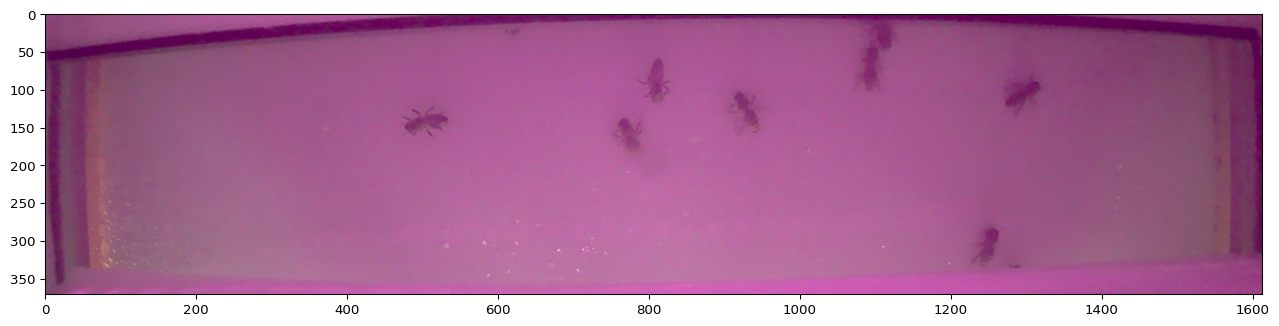

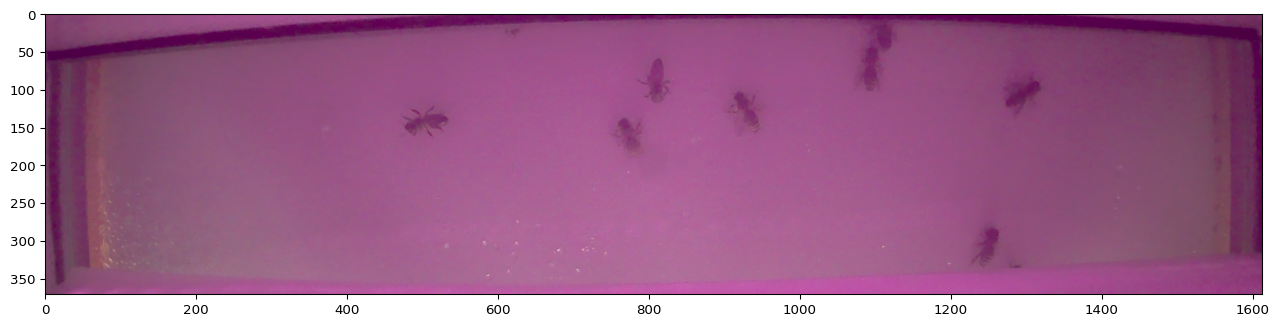

In [69]:
%matplotlib inline

img = test_set.load_image(1)
rotated_image=augmentation.augment_image(img)
ia.imshow(rotated_image)
rotated_image=augmentation.augment_image(img)
ia.imshow(rotated_image)

### Train Model

In [ ]:
try:
    model.train(train_set,
            validation_set,
            custom_callbacks = [early_stopping, reduce_lr],
            learning_rate = train_cfg.LEARNING_RATE,
            epochs = 1000, 
            layers = 'heads',            # all
            augmentation = (augmentation if train_cfg.USE_AUGMENTATION else None))
except Exception as e:
    f = open("error.log", "a")
    f.writelines(str(e) + "\n") 
    f.close()

### Plot Training Results

Text(0.5, 1.0, 'val_mrcnn_class_loss')

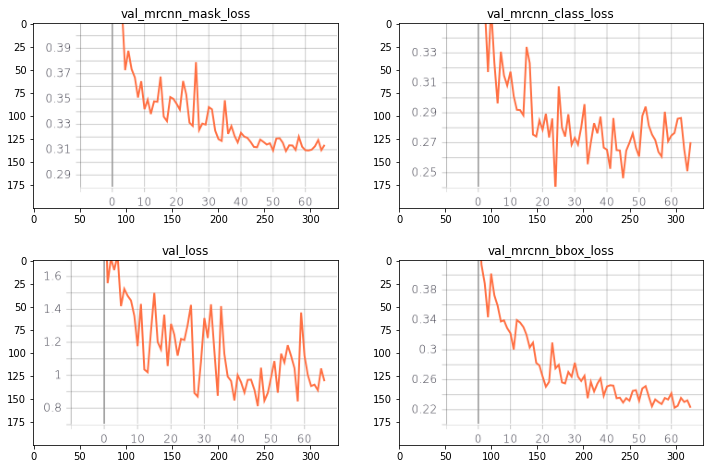

In [99]:
%matplotlib inline
from IPython.display import display, Image

img1 = mpimg.imread('./val_loss.png')
img2 = mpimg.imread('./val_mrcnn_bbox_loss.png')
img3 = mpimg.imread('./val_mrcnn_mask_loss.png')
img4 = mpimg.imread('./val_mrcnn_class_loss.png')

fig = plt.figure(figsize=[12,16])
a = fig.add_subplot(1, 2, 1)
imgplot = plt.imshow(img1)
a.set_title('val_loss')
a = fig.add_subplot(1, 2, 2)
imgplot = plt.imshow(img2)
a.set_title('val_mrcnn_bbox_loss')
a = fig.add_subplot(2, 2, 1)
imgplot = plt.imshow(img3)
a.set_title('val_mrcnn_mask_loss')
a = fig.add_subplot(2, 2, 2)
imgplot = plt.imshow(img4)
a.set_title('val_mrcnn_class_loss')

---
# Evaluation

### Define Evaluation Config

In [ ]:
# define a configuration for the model
class EvaluationConfig(Config):
    NAME = "eval_cfg"
    NUM_CLASSES = 1 + 1
    BACKBONE = "resnet50"
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    INF_TIME_ITERATIONS = 100
    RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256)
    #DETECTION_MIN_CONFIDENCE = 0.9
    # MEAN_PIXEL = 0
    
# create config
eval_cfg = EvaluationConfig()
#eval_cfg.display()

### Initizalize Models

In [ ]:
# Baseline - Resnet 50
model_resnet50=BeeMaskRCNN(mode='inference', model_dir=global_cfg.DEFAULT_LOGS_DIR, config=eval_cfg)
weights_path = 'logs/baseline_restnet50_20210112T1031/mask_rcnn_baseline_restnet50__0094.h5'
model_resnet50.load_weights(weights_path, by_name=True)
print("Model model_resnet50 loaded!")

In [ ]:
# ResNet 101
eval_cfg.backbone = "resnet101"
model_resnet101=BeeMaskRCNN(mode='inference', model_dir=global_cfg.DEFAULT_LOGS_DIR, config=eval_cfg)
weights_path = 'logs/baseline_restnet101_20210113T1024/mask_rcnn_baseline_restnet101__0042.h5'
model_resnet101.load_weights(weights_path, by_name=True)
print("Model model_resnet101 loaded!")

In [ ]:
# with image augmantation
model_resnet50_aug=BeeMaskRCNN(mode='inference', model_dir=global_cfg.DEFAULT_LOGS_DIR, config=eval_cfg)
weights_path = 'logs/imgaug_restnet50_20210122T1934/mask_rcnn_imgaug_restnet50__0054.h5'
model_resnet50_aug.load_weights(weights_path, by_name=True)
print("Model model_resnet50_aug loaded!")

In [ ]:
# with changed RPN anchor scales and image dimensions
rpn_anchor_scales_u_image_dim_50percent=BeeMaskRCNN(mode='inference', model_dir=global_cfg.DEFAULT_LOGS_DIR, config=eval_cfg)
weights_path = 'logs/rpn_anchor_scales_u_image_dim_50percent_restnet50_20210124T0943/mask_rcnn_rpn_anchor_scales_u_image_dim_50percent_restnet50__0046.h5'
rpn_anchor_scales_u_image_dim_50percent.load_weights(weights_path, by_name=True)
print("Model rpn_anchor_scales_u_image_dim_50percent loaded!")

In [ ]:
# SGD LR 0.01
lr01=BeeMaskRCNN(mode='inference', model_dir=global_cfg.DEFAULT_LOGS_DIR, config=eval_cfg)
weights_path = 'logs/lr01_restnet50_20210124T1927/mask_rcnn_lr01_restnet50__0029.h5'
lr01.load_weights(weights_path, by_name=True)
print("Model lr01 loaded!")

In [ ]:
# ADAM LR 0.001
adam=BeeMaskRCNN(mode='inference', model_dir=global_cfg.DEFAULT_LOGS_DIR, config=eval_cfg)
weights_path = 'logs/adam_lr001_restnet50_20210126T1228/mask_rcnn_adam_lr001_restnet50__0047.h5'
adam.load_weights(weights_path, by_name=True)
print("Model adam loaded!")

In [ ]:
# ADAM LR 0.01
adam01=BeeMaskRCNN(mode='inference', model_dir=global_cfg.DEFAULT_LOGS_DIR, config=eval_cfg)
weights_path = 'logs/adam_lr01_restnet50_20210127T0002/mask_rcnn_adam_lr01_restnet50__0015.h5'
adam01.load_weights(weights_path, by_name=True)
print("Model adam01 loaded!")

In [ ]:
# ADAM LR 0.0001
adam0001=BeeMaskRCNN(mode='inference', model_dir=global_cfg.DEFAULT_LOGS_DIR, config=eval_cfg)
weights_path = 'logs/adam_lr0001_restnet50_20210127T1144/mask_rcnn_adam_lr0001_restnet50__0040.h5'
adam0001.load_weights(weights_path, by_name=True)
print("Model adam0001 loaded!")

In [ ]:
# ADAM LR 0.00001
adam00001=BeeMaskRCNN(mode='inference', model_dir=global_cfg.DEFAULT_LOGS_DIR, config=eval_cfg)
weights_path = 'logs/adam_lr00001_restnet50_20210127T2209/mask_rcnn_adam_lr00001_restnet50__0057.h5'
adam00001.load_weights(weights_path, by_name=True)
print("Model adam00001 loaded!")

In [ ]:
# SGD LR 0.0001
sgd0001=BeeMaskRCNN(mode='inference', model_dir=global_cfg.DEFAULT_LOGS_DIR, config=eval_cfg)
weights_path = 'logs/sgd_lr0001_restnet50_20210128T1139/mask_rcnn_sgd_lr0001_restnet50__0036.h5'
sgd0001.load_weights(weights_path, by_name=True)
print("Model sgd0001 loaded!")

In [ ]:
# SGD 0.00001
sgd00001=BeeMaskRCNN(mode='inference', model_dir=global_cfg.DEFAULT_LOGS_DIR, config=eval_cfg)
weights_path = 'logs/sgd_lr00001_restnet50_20210128T2156/mask_rcnn_sgd_lr00001_restnet50__0007.h5'
sgd00001.load_weights(weights_path, by_name=True)
print("Model sgd00001 loaded!")

In [ ]:
# ADAM L1 - Regulraization
adaml1=BeeMaskRCNN(mode='inference', model_dir=global_cfg.DEFAULT_LOGS_DIR, config=eval_cfg)
weights_path = 'logs/adam_l1_restnet50_20210129T0739/mask_rcnn_adam_l1_restnet50__0015.h5'
adaml1.load_weights(weights_path, by_name=True)
print("Model adaml1 loaded!")

In [ ]:
# ADAM L122 - Regulraization
adaml1l2=BeeMaskRCNN(mode='inference', model_dir=global_cfg.DEFAULT_LOGS_DIR, config=eval_cfg)
weights_path = 'logs/adam_l1l2_restnet50_20210129T1416/mask_rcnn_adam_l1l2_restnet50__0040.h5'
adaml1l2.load_weights(weights_path, by_name=True)
print("Model adaml1l2 loaded!")

In [112]:
# ADAM ROI's 16,32,64,128,256
eval_cfg.RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256)
rois22=BeeMaskRCNN(mode='inference', model_dir=global_cfg.DEFAULT_LOGS_DIR, config=eval_cfg)
weights_path = 'logs/adam_rois2_restnet50_20210130T1517/mask_rcnn_adam_rois2_restnet50__0068.h5'
rois22.load_weights(weights_path, by_name=True)
print("Model rois22 loaded!")

Model rois22 loaded!


In [ ]:
# SGD ROI's 16,32,64,128,256
eval_cfg.RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256)
sgd_rois2=BeeMaskRCNN(mode='inference', model_dir=global_cfg.DEFAULT_LOGS_DIR, config=eval_cfg)
weights_path = 'logs/sgd_rois2_restnet50_20210131T1002/mask_rcnn_sgd_rois2_restnet50__0026.h5'
sgd_rois2.load_weights(weights_path, by_name=True)
print("Model sgd_rois2 loaded!")

## Assign model

In [113]:
# set correct model
model = rois22

### Define Evaluation Function

In [32]:
# calculate the mAP for a model on a given dataset
def evaluate_model(model, dataset, cfg, iou_threshold):
    
    print(cfg.backbone)
    APs = list()
    
    # dataset.image_ids     range(5)
    for image_id in dataset.image_ids: 
        
        # load image, bounding boxes and masks for the image id
        image, _, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, augmentation=None, use_mini_mask=False)

        # make prediction
        results = model.detect([image], verbose=0)
        r = results[0]
        
        # if no bounding boxes are set continue with next image
        if(len(gt_bbox) == 0):
            continue
 
        # calculate statistics, including AP
        AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'], iou_threshold=iou_threshold)
        # store
        APs.append(AP)

    # calculate the mean AP across all images
    mAP = mean(APs)
    return mAP

### Evaluate Model

In [33]:
def evalute_model_multiple(model, validation_set, test_set, eval_cfg):
    
    # open file mAP.md and append model evaluation 
    f = open("mAP.md", "a")
    f.writelines("Model: " + model.get_model().name+"\n") 

    for iou in [0.5,0.75,0.9]:
        # evaluate model on training dataset
        #val_mAP = evaluate_model(model, validation_set, eval_cfg, iou)
        #f.writelines("Validation: IoU: "+str(iou)+" mAP: "+str(val_mAP) +"\n") 
        #print("Validation: IoU: "+str(iou)+" mAP: "+str(val_mAP)+"\n")

        # evaluate model on test dataset
        test_mAP = evaluate_model(model, test_set, eval_cfg, iou)
        f.writelines("Test: IoU: "+str(iou)+" mAP: "+str(test_mAP)+"\n") 
        print("Test: IoU: "+str(iou)+" mAP: "+str(test_mAP)+"\n")

    f.close()

In [41]:
eval_cfg.DETECTION_MIN_CONFIDENCE = 0.9
evalute_model_multiple(model, validation_set, test_set, eval_cfg)

resnet50
Test: IoU: 0.5 mAP: 0.7680561927042306

resnet50
Test: IoU: 0.75 mAP: 0.21776470212067317

resnet50
Test: IoU: 0.9 mAP: 0.0032866670134605856



---
# Visualization

### Differences between ground truth and prediction: Score/IoU

In [114]:
def visualize_prediction(model, test_set, test_set_id):

    # load specially selected pictures (for example pictures with problematic lighting) from testdata
    img = test_set.load_image(test_set_id)   # 200
    masks, class_ids = test_set.load_mask(test_set_id)  # 200
    bbox = utils.extract_bboxes(masks)

    # make prediction
    results = model.detect([img], verbose=0)
    r = results[0]

    visualize.display_differences(image=img*255,
                                    gt_box=bbox, gt_class_id=class_ids, gt_mask=masks, pred_box=r['rois'], 
                                    pred_class_id=r['class_ids'], pred_score=r['scores'], pred_mask=r['masks'],
                                    class_names=test_set.class_names, title=None, ax=None,
                                    show_mask=False, show_box=True,
                                    iou_threshold=0.5, score_threshold=0.5)
    print()

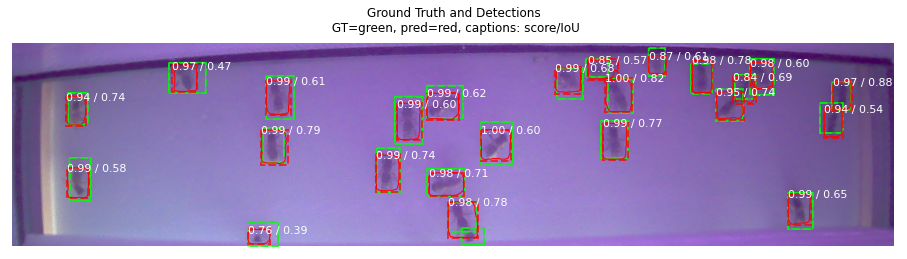

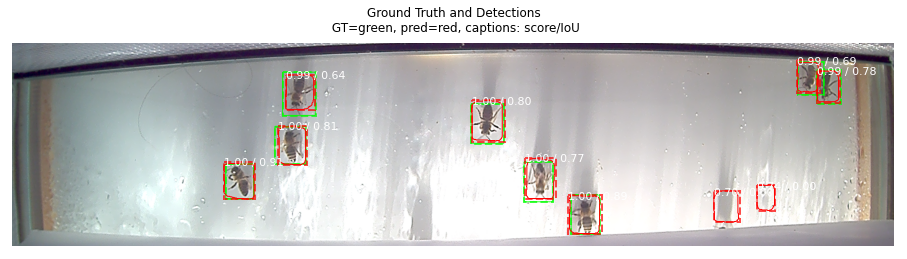

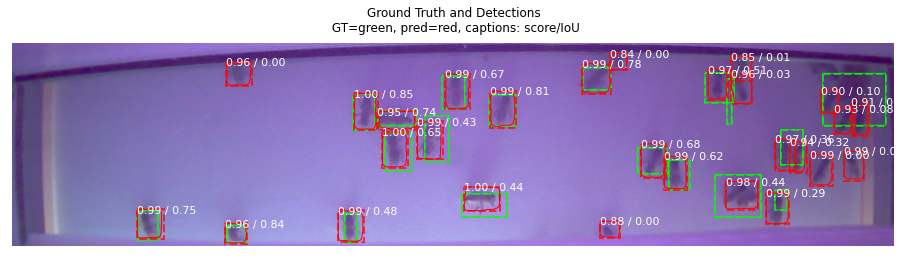

In [169]:
visualize_prediction(model,test_set, 100) # sample of full detection
visualize_prediction(model,test_set, 20) # sample of bad prediction -> higher confidence
visualize_prediction(model,train_set, len(train_set.image_ids)-2) # sample of bad labeling

---
# Inference Time

---

### Measure Inference Time

In [23]:
def print_avg_inf_time(model, img, inf_iterations):
           
    # innitialize inference
    print('initializing inference')
    _ = model.detect([img], verbose=0)
    
    # calculate average inference time
    print('measuring inference time')
    avg_inf_time = 0

    for _ in range(inf_iterations):
        start_time = time.time()
        prediction = model.detect([img], verbose=0)
        end_time = time.time()

        inf_time = end_time - start_time
        avg_inf_time += inf_time

    avg_inf_time = int((avg_inf_time / inf_iterations) * 1000)

    print('average inferece time after {} iterations: {} ms'.format(inf_iterations,avg_inf_time))

img = test_set.load_image(1)

In [24]:
# mit augmantation
print_avg_inf_time(model, img, eval_cfg.INF_TIME_ITERATIONS)

initializing inference
measuring inference time
average inferece time after 100 iterations: 274 ms
